In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [34]:
df_dir_1 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/cleaned/linreg_exploration_dir_1_cleaned.csv')
df_dir_2 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/cleaned/linreg_exploration_dir_2_cleaned.csv')

In [35]:
lines_dir_1 = sorted(list(df_dir_1['LINEID'].unique()))
lines_dir_1

['1',
 '102',
 '104',
 '11',
 '111',
 '114',
 '116',
 '120',
 '122',
 '123',
 '13',
 '130',
 '14',
 '140',
 '142',
 '145',
 '14C',
 '15',
 '150',
 '151',
 '15A',
 '15B',
 '15D',
 '16',
 '161',
 '16C',
 '16D',
 '17',
 '17A',
 '18',
 '184',
 '185',
 '220',
 '236',
 '238',
 '239',
 '25',
 '25A',
 '25B',
 '25D',
 '25X',
 '26',
 '27',
 '270',
 '27A',
 '27B',
 '27X',
 '29A',
 '31',
 '31A',
 '31B',
 '31D',
 '32',
 '32X',
 '33',
 '33A',
 '33B',
 '33D',
 '33E',
 '33X',
 '37',
 '38',
 '38A',
 '38B',
 '38D',
 '39',
 '39A',
 '39X',
 '4',
 '40',
 '40B',
 '40D',
 '40E',
 '41',
 '41B',
 '41C',
 '41D',
 '41X',
 '42',
 '42D',
 '43',
 '44',
 '44B',
 '45A',
 '46A',
 '47',
 '49',
 '51D',
 '53',
 '54A',
 '56A',
 '59',
 '61',
 '63',
 '65',
 '65B',
 '66',
 '66A',
 '66B',
 '66X',
 '67',
 '67X',
 '68',
 '68A',
 '69',
 '69X',
 '7',
 '70',
 '70D',
 '75',
 '76',
 '76A',
 '77A',
 '79',
 '79A',
 '7A',
 '7B',
 '7D',
 '83',
 '83A',
 '84',
 '84A',
 '84X',
 '9']

To determine if there are any pairwise interactions, I will complete the following code for a number of lines individually. This is because of the large variation in mean trip length, shown in feature_pairwise_interactions. To begin with, I will find the lines with the most rows. This will allow better representation of the effect of different features on the target variable.

In [36]:
max_rows = 0
for line in lines_dir_1:
    number_rows = df_dir_1[df_dir_1['LINEID']==line].shape[0]
    if number_rows > max_rows:
        max_rows = number_rows
        max_line = line
        print(max_rows, line)


5921 1
6323 122
8146 123
8366 130
10243 145
13166 46A


The 5 lines with the most rows are shown above.
We will begin with the 46A.

In [37]:
highest_n_rows = ['46A','145','130','123','122']

Performing test_train_split

In [38]:
for line in highest_n_rows:
    print("Now doing line", str(line))
    df_temp = df_dir_1[df_dir_1['LINEID']==line]
    df_temp.set_index(np.random.permutation(df_temp.index))
    df_temp.sort_index(inplace=True)
    df_temp.drop(columns=['TRIPID', 'DIRECTION', 'LINEID','ROUTEID'], inplace=True)

    X = df_temp.drop(columns=["TRIPTIME"], axis=1)
    y = pd.DataFrame(df_temp['TRIPTIME'])

    # do test train split
    # Split the dataset into two datasets: 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1)
    # Select columns containing categorical data
    categorical_cols = X_train.select_dtypes('object').columns
    categorical_cols = categorical_cols.append(
    X_train[['WEEKDAY','HOUR','MONTH','RUSHHOUR','weather_id','weather_main','weather_description','snow_ice','heavy_precip']].columns)

    # Convert data type to category for these columns
    for col in categorical_cols:
        X_train[col] = X_train[col].astype('category')
    continuous_cols = X_train.select_dtypes(['float64','int64']).columns

    # dict to hold correlation values 
    corr_dict = {}

    # plot pairwise interaction between all continuous features and target
    for column in X_train[continuous_cols]:
        # create temp df to merge column and target
        df_temp = pd.concat([X_train[column], y_train], axis=1)
        # store correlation in variable
        correlation = df_temp[[column, "TRIPTIME"]].corr().values[0,1]
        # add correlation to dict
        corr_dict[column] = correlation

        # dataframe holding sorted correlation values to aid in interpreting results
        corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['TRIPTIME']).sort_values('TRIPTIME', ascending=False)

    corr = X_train[continuous_cols].corr()
    print("Relationship between continuous features:")
    print(corr)
    print("Relationship between continuous features with triptime:")
    print(corr_df)



Now doing line 46A
Relationship between continuous features:
                temp  dew_point  feels_like  temp_min  temp_max  pressure  \
temp        1.000000   0.836904    0.987627  0.996516  0.989676  0.241340   
dew_point   0.836904   1.000000    0.857592  0.837293  0.834228  0.091091   
feels_like  0.987627   0.857592    1.000000  0.983451  0.980212  0.260874   
temp_min    0.996516   0.837293    0.983451  1.000000  0.988939  0.236831   
temp_max    0.989676   0.834228    0.980212  0.988939  1.000000  0.247918   
pressure    0.241340   0.091091    0.260874  0.236831  0.247918  1.000000   
humidity   -0.521431   0.021710   -0.468797 -0.513481 -0.505271 -0.314017   
wind_speed -0.087862  -0.167756   -0.183921 -0.082932 -0.104547 -0.278080   
wind_deg   -0.082454  -0.061138   -0.071336 -0.089058 -0.106764  0.011815   
rain_1h    -0.090990   0.046054   -0.095442 -0.086554 -0.084966 -0.304432   
snow_1h    -0.130199  -0.153883   -0.147051 -0.135923 -0.129598  0.010109   
clouds_all -0.1

Although their are variations for the correlation of each feature as we were looking at a number of lines, I have grouped them into the following brackets based upon the best correlation value shown.

<b>Positive correlations</b>

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.15       | 0.15 < x < 0.25    | x >= 0.25        |
| feels_like, rain_1h, wind_deg, clouds_all    | temp_min, temp, temp_max, wind_speed,       | no features|


<b>Negative correlations</b>

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x >= -0.15      | -0.15 > x > -0.25  | x <= -0.25       |
| snow_1h, dew_point, pressure     | humidity        | no features       |

The most informative features are shown as 'temp_min','temp_max','temp','wind_speed' and 'humidity'. The correlations between continuous features show strong correlations between features 'temp','temp_min' and 'temp_max'. For simplicity, I will keep just 'temp'.

I will drop the other features from the dataframe as they are unlikely to contribute to the model.

In [39]:
features_to_drop = ['feels_like','rain_1h','wind_deg','clouds_all','snow_1h','dew_point','pressure', 'temp_min','temp_max']
high_correlations_features = ['temp','wind_speed','humidity']

In [40]:
df_dir_1 = df_dir_1.drop(columns=features_to_drop, axis=1)
df_dir_1

temp  humidity  wind_speed  weather_id weather_main  \
0       5.39        75        5.10         500         Rain   
1       5.39        81        3.10         500         Rain   
2       5.39        81        3.10         500         Rain   
3       5.39        81        3.10         500         Rain   
4       5.39        81        3.10         500         Rain   
...      ...       ...         ...         ...          ...   
354150  9.85        79        0.89         803       Clouds   
354151  9.76        80        1.79         803       Clouds   
354152  9.76        80        1.79         803       Clouds   
354153  9.76        80        1.79         803       Clouds   
354154  9.76        80        1.79         803       Clouds   

       weather_description  snow_ice  heavy_precip  HOUR   TRIPID LINEID  \
0               light rain         0             0     5  5963422     65   
1               light rain         0             0     6  5969148     14   
2               light rain         0             0     6  5962897     39   
3               light rain         0             0     6  5963890    140   
4               light rain         0             0     6  5962251    123   
...                    ...       ...           ...   ...      ...    ...   
354150       broken clouds         0             0    21  8576222    25B   
354151       broken clouds         0             0    22  8580939    130   
354152       broken clouds         0             0    22  8587935    27B   
354153       broken clouds         0             0    22  8589536    120   
354154       broken clouds         0             0    22  8584078    25A   

        ROUTEID  DIRECTION  TRIPTIME  WEEKDAY  MONTH  RUSHHOUR  
0         65_73          1    4425.0        1      1         0  
1         14_15          1    4281.0        1      1         1  
2         39_20          1    3758.0        1      1         1  
3        140_19          1    2732.0        1      1         1  
4        123_34          1    2658.0        1      1         1  
...         ...        ...       ...      ...    ...       ...  
354150  25B_274          1    2559.0        0     12         0  
354151   130_10          1    1734.0        0     12         0  
354152   27B_23          1    2108.0        0     12         0  
354153   120_12          1    1327.0        0     12         0  
354154  25A_273          1    2745.0        0     12         0  

[354155 rows x 17 columns]

Create stacked bar plots for all categorical features

In [41]:
# barplot function
def bar_plot(col1, col2,df):
    df.groupby(col1)[col2].mean().plot.bar(cmap='Pastel2')
    plt.title(col1 + " vs " + col2)
    plt.xticks(rotation=45)
    plt.tight_layout()

# boxplot
def boxplot_time(col1,X_train, y_train):
    sns.boxplot(x=X_train[col1], y=y_train['TRIPTIME'], palette='pastel')
    plt.title(col1 + " vs Trip Time")
    plt.xticks(rotation=45)
    plt.tight_layout()


Plotting categorical pairwise interactions for only the line with the highest number of rows (46A)

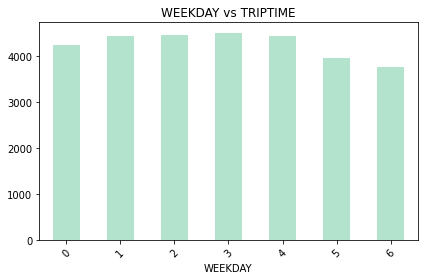

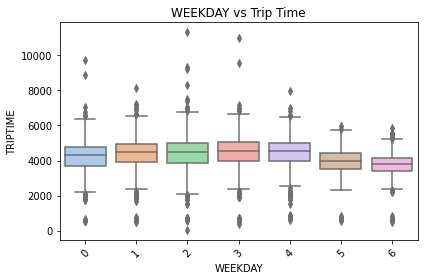

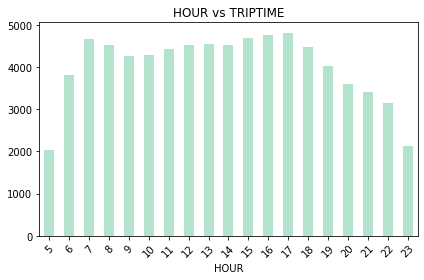

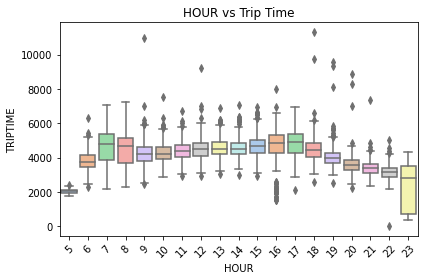

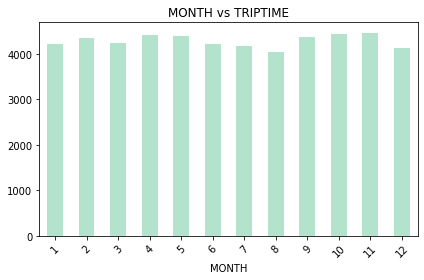

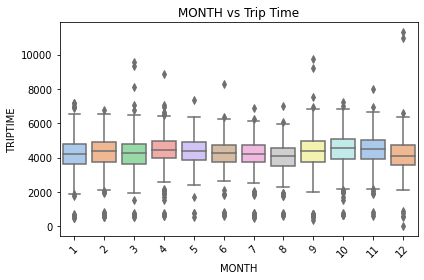

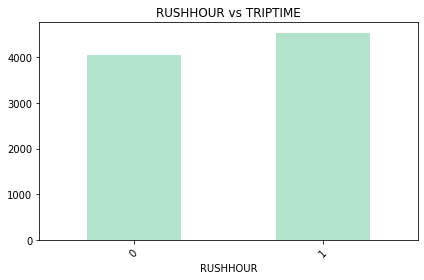

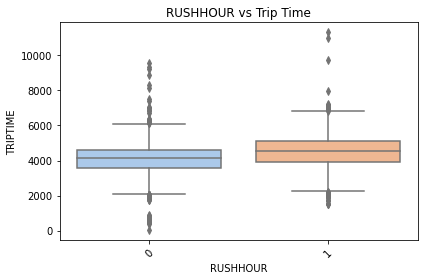

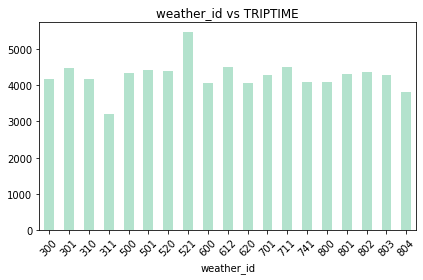

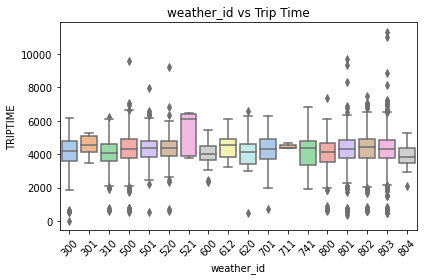

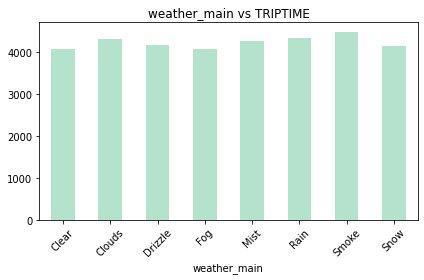

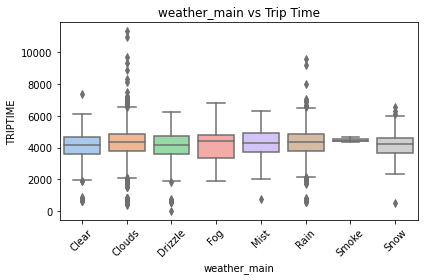

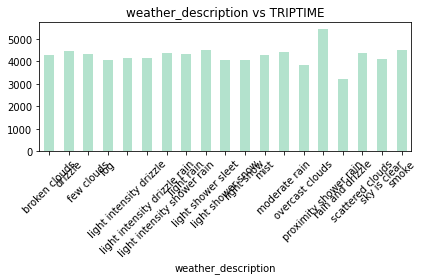

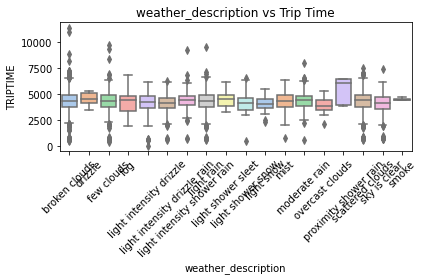

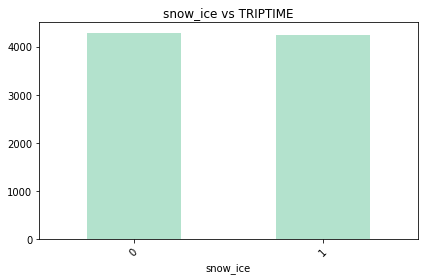

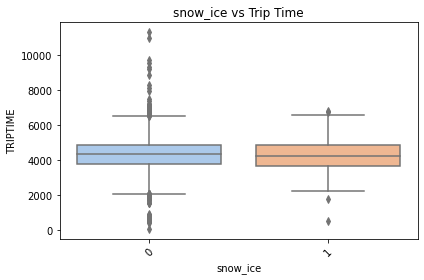

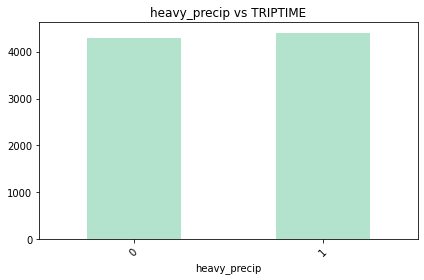

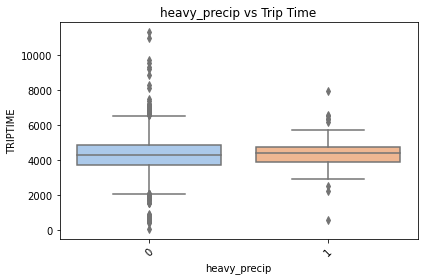

In [42]:
df_temp = df_dir_1[df_dir_1['LINEID'] == '46A']
df_temp.set_index(np.random.permutation(df_temp.index))
df_temp.sort_index(inplace=True)
df_temp.drop(columns=['TRIPID', 'DIRECTION',
                      'LINEID', 'ROUTEID'], inplace=True)

X = df_temp.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_temp['TRIPTIME'])

# do test train split
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=1)
 # Select columns containing categorical data
categorical_cols = X_train[['WEEKDAY', 'HOUR', 'MONTH', 'RUSHHOUR', 'weather_id', 'weather_main', 'weather_description', 'snow_ice', 'heavy_precip']].columns

# Convert data type to category for these columns
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
continuous_cols = X_train.select_dtypes(['float64', 'int64']).columns

for col in categorical_cols:
    bar_plot(col, 'TRIPTIME', df_temp)
    plt.show()
    boxplot_time(col, X_train, y_train)
    plt.show()


* weather_main showing low information gain
* Weather_description: overcast clouds shows large difference in median temp compared to other weather descriptions on triptime
* weekday: Lower mean values for weekend vs weekday triptimes
* hour: 5:00 and 23:00 show much lower mean triptime values vs other hours
    * 7,8,16 and 17 also showing higher median values when compared to other times of the day
* month: little difference between month mean triptimes
* rushhour: non-rushhour mean and median triptimes noticably lower than rushhour triptimes
    * similar to hour, hour more accurate so will keep this one
* weather_id: 521 weather id showing significantly higher mean and median triptime compared to other weather id's - will investigate further
* snow_ice showing little information gain
* heavy_precip showing larger variation in values compared to those flagged as non heavy. will investigate further

In [43]:
categorical_low_info_gain = ['weather_main','weather_description','RUSHHOUR','snow_ice']
categorical_med_info_gain = ['MONTH','heavy_precip','weather_id']
categorical_high_info_gain = ['HOUR','WEEKDAY']

In [44]:
df_dir_1 = df_dir_1.drop(columns=categorical_low_info_gain, axis=1)

In [45]:
df_dir_1.to_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_prep/feature_pairwise_cleaned_dir1.csv', index=False)

## Direction 2
Repeat the same steps for direction 2

In [47]:
lines_dir_2 = sorted(list(df_dir_2['LINEID'].unique()))
lines_dir_2

['1',
 '102',
 '104',
 '11',
 '111',
 '114',
 '116',
 '118',
 '120',
 '122',
 '123',
 '13',
 '130',
 '14',
 '140',
 '142',
 '145',
 '14C',
 '15',
 '150',
 '151',
 '15A',
 '15B',
 '15D',
 '16',
 '161',
 '16C',
 '17',
 '17A',
 '18',
 '184',
 '185',
 '220',
 '236',
 '238',
 '239',
 '25',
 '25A',
 '25B',
 '25D',
 '25X',
 '26',
 '27',
 '270',
 '27A',
 '27B',
 '27X',
 '29A',
 '31',
 '31A',
 '31B',
 '31D',
 '32',
 '32X',
 '33',
 '33A',
 '33B',
 '33D',
 '33X',
 '37',
 '38',
 '38A',
 '38B',
 '38D',
 '39',
 '39A',
 '39X',
 '4',
 '40',
 '40B',
 '40D',
 '40E',
 '41',
 '41A',
 '41B',
 '41C',
 '41D',
 '41X',
 '42',
 '42D',
 '43',
 '44',
 '44B',
 '45A',
 '46A',
 '46E',
 '47',
 '49',
 '51D',
 '51X',
 '53',
 '54A',
 '56A',
 '59',
 '61',
 '63',
 '65',
 '65B',
 '66',
 '66A',
 '66B',
 '66X',
 '67',
 '67X',
 '68',
 '68A',
 '68X',
 '69',
 '69X',
 '7',
 '70',
 '70D',
 '75',
 '76',
 '76A',
 '77A',
 '77X',
 '79',
 '79A',
 '7A',
 '7B',
 '7D',
 '83',
 '83A',
 '84',
 '84A',
 '84X',
 '9']

In [48]:
max_rows = 0
for line in lines_dir_2:
    number_rows = df_dir_2[df_dir_2['LINEID']==line].shape[0]
    if number_rows > max_rows:
        max_rows = number_rows
        max_line = line
        print(max_rows, line)


6229 1
7826 123
8584 130
9976 145
12745 46A


The 5 lines with the most rows are shown above.
We will begin with the 46A.

In [49]:
highest_n_rows = ['46A','145','130','123','122']

Performing test_train_split

In [50]:
for line in highest_n_rows:
    print("Now doing line", str(line))
    df_temp = df_dir_2[df_dir_2['LINEID']==line]
    df_temp.set_index(np.random.permutation(df_temp.index))
    df_temp.sort_index(inplace=True)
    df_temp.drop(columns=['TRIPID', 'DIRECTION', 'LINEID','ROUTEID'], inplace=True)

    X = df_temp.drop(columns=["TRIPTIME"], axis=1)
    y = pd.DataFrame(df_temp['TRIPTIME'])

    # do test train split
    # Split the dataset into two datasets: 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1)
    # Select columns containing categorical data
    categorical_cols = X_train.select_dtypes('object').columns
    categorical_cols = categorical_cols.append(
    X_train[['WEEKDAY','HOUR','MONTH','RUSHHOUR','weather_id','weather_main','weather_description','snow_ice','heavy_precip']].columns)

    # Convert data type to category for these columns
    for col in categorical_cols:
        X_train[col] = X_train[col].astype('category')
    continuous_cols = X_train.select_dtypes(['float64','int64']).columns

    # dict to hold correlation values 
    corr_dict = {}

    # plot pairwise interaction between all continuous features and target
    for column in X_train[continuous_cols]:
        # create temp df to merge column and target
        df_temp = pd.concat([X_train[column], y_train], axis=1)
        # store correlation in variable
        correlation = df_temp[[column, "TRIPTIME"]].corr().values[0,1]
        # add correlation to dict
        corr_dict[column] = correlation

        # dataframe holding sorted correlation values to aid in interpreting results
        corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['TRIPTIME']).sort_values('TRIPTIME', ascending=False)

    corr = X_train[continuous_cols].corr()
    print("Relationship between continuous features:")
    print(corr)
    print("Relationship between continuous features with triptime:")
    print(corr_df)



Now doing line 46A
Relationship between continuous features:
                temp  dew_point  feels_like  temp_min  temp_max  pressure  \
temp        1.000000   0.829174    0.987297  0.996470  0.990818  0.253543   
dew_point   0.829174   1.000000    0.851430  0.829133  0.827169  0.113553   
feels_like  0.987297   0.851430    1.000000  0.982954  0.980832  0.272198   
temp_min    0.996470   0.829133    0.982954  1.000000  0.989972  0.250808   
temp_max    0.990818   0.827169    0.980832  0.989972  1.000000  0.263018   
pressure    0.253543   0.113553    0.272198  0.250808  0.263018  1.000000   
humidity   -0.563833  -0.014883   -0.510360 -0.556512 -0.548770 -0.296475   
wind_speed -0.072662  -0.157413   -0.170070 -0.067633 -0.091269 -0.270077   
wind_deg   -0.072771  -0.062948   -0.062948 -0.080867 -0.095720  0.031677   
rain_1h    -0.087177   0.045077   -0.090169 -0.083203 -0.085846 -0.284911   
snow_1h    -0.143748  -0.169824   -0.160678 -0.145680 -0.142692  0.021756   
clouds_all -0.1

Although their are variations for the correlation of each feature as we were looking at a number of lines, I have grouped them into the following brackets based upon the best correlation value shown.

<b>Positive correlations</b>

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.15       | 0.15 < x < 0.25    | x >= 0.25        |
| clouds_all, temp_min, temp, wind_deg, temp_max, feels_like, rain_1h  | wind_speed | no features|


<b>Negative correlations</b>

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x >= -0.15      | -0.15 > x > -0.25  | x <= -0.25       |
| snow_1h, dew_point, pressure     | humidity        | no features       |

The most informative features are shown as 'wind_speed' and 'humidity'. There are no strong correlations shown between these features and any other features so I will keep both.

I will drop the other features from the dataframe as they are unlikely to contribute to the model.

In [51]:
features_to_drop = ['feels_like','rain_1h','wind_deg','clouds_all','snow_1h','dew_point','pressure', 'temp_min','temp_max', 'temp']
high_correlations_features = ['wind_speed','humidity']

In [52]:
df_dir_2 = df_dir_2.drop(columns=features_to_drop, axis=1)
df_dir_2

humidity  wind_speed  weather_id weather_main weather_description  \
0             75        5.10         500         Rain          light rain   
1             75        5.10         500         Rain          light rain   
2             81        3.10         500         Rain          light rain   
3             81        3.10         500         Rain          light rain   
4             81        3.10         500         Rain          light rain   
...          ...         ...         ...          ...                 ...   
352475        79        0.89         803       Clouds       broken clouds   
352476        80        1.79         803       Clouds       broken clouds   
352477        80        1.79         803       Clouds       broken clouds   
352478        80        1.79         803       Clouds       broken clouds   
352479        80        1.79         803       Clouds       broken clouds   

        snow_ice  heavy_precip  HOUR   TRIPID LINEID  ROUTEID  DIRECTION  \
0              0             0     5  5962263     40    40_31          2   
1              0             0     5  5963304     40    40_31          2   
2              0             0     6  5958381    15B   15B_61          2   
3              0             0     6  5971085    15B   15B_61          2   
4              0             0     6  5963272     7B    7B_93          2   
...          ...           ...   ...      ...    ...      ...        ...   
352475         0             0    21  8584834    145  145_105          2   
352476         0             0    22  8581813    40E   40E_91          2   
352477         0             0    22  8586917    27B   27B_34          2   
352478         0             0    22  8582081     32    32_58          2   
352479         0             0    22  8589189    40D  40D_103          2   

        TRIPTIME  WEEKDAY  MONTH  RUSHHOUR  
0         4574.0        1      1         0  
1         4106.0        1      1         0  
2         3433.0        1      1         1  
3         2976.0        1      1         1  
4         4352.0        1      1         1  
...          ...      ...    ...       ...  
352475    4289.0        0     12         0  
352476    1469.0        0     12         0  
352477    2388.0        0     12         0  
352478    2095.0        0     12         0  
352479    2308.0        0     12         0  

[352480 rows x 16 columns]

Create stacked bar plots for all categorical features

Plotting categorical pairwise interactions for only the line with the highest number of rows (46A)

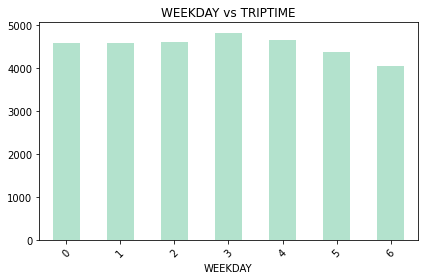

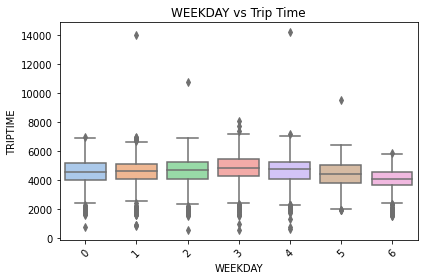

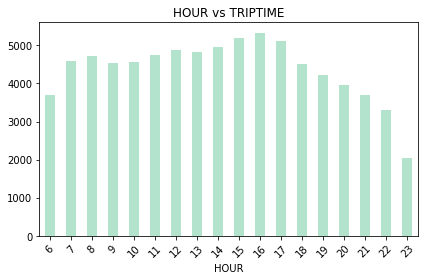

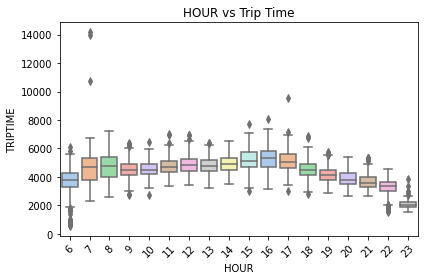

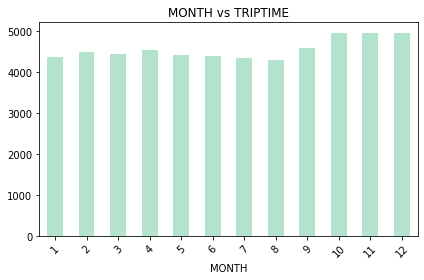

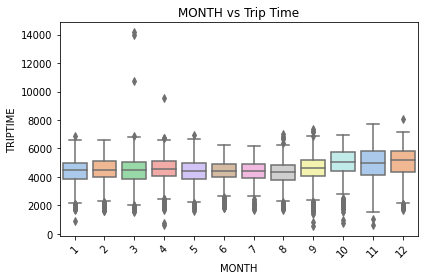

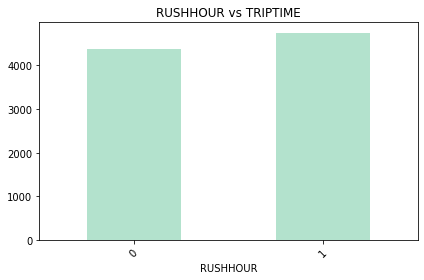

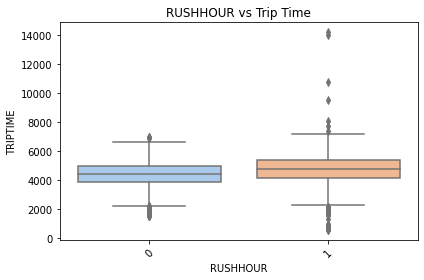

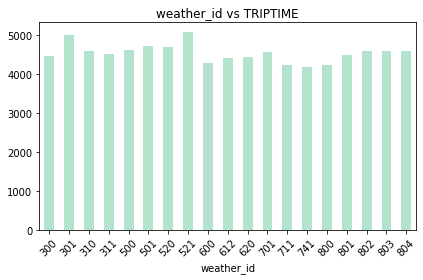

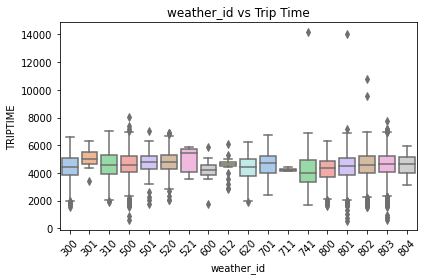

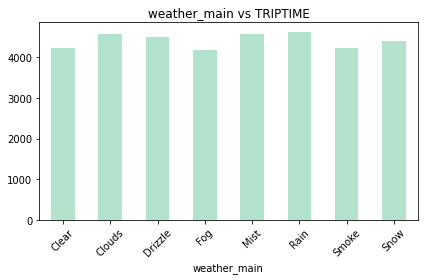

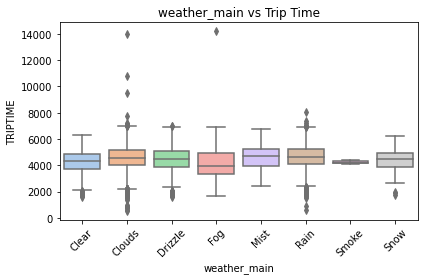

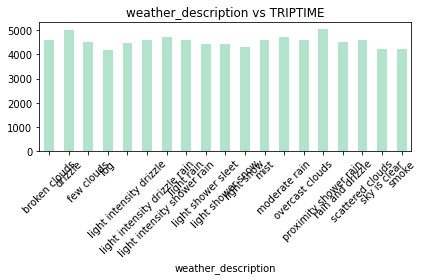

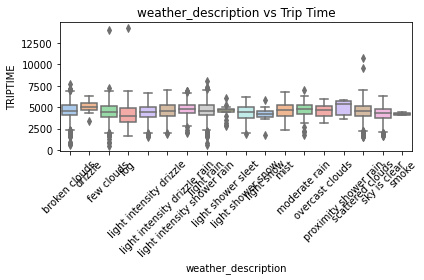

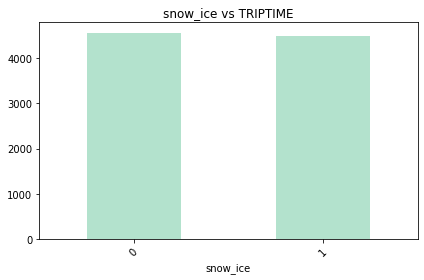

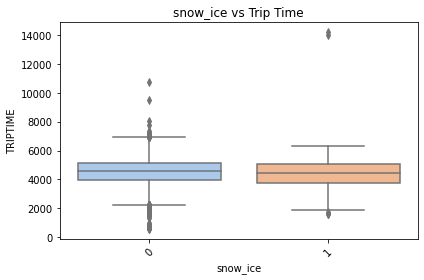

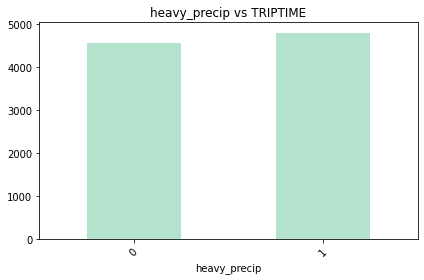

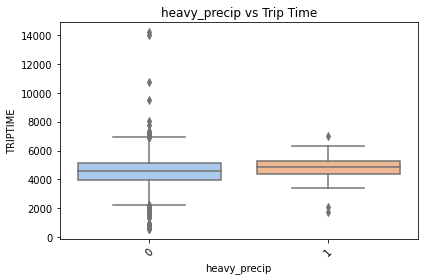

In [53]:
df_temp = df_dir_2[df_dir_2['LINEID'] == '46A']
df_temp.set_index(np.random.permutation(df_temp.index))
df_temp.sort_index(inplace=True)
df_temp.drop(columns=['TRIPID', 'DIRECTION',
                      'LINEID', 'ROUTEID'], inplace=True)

X = df_temp.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_temp['TRIPTIME'])

# do test train split
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=1)
 # Select columns containing categorical data
categorical_cols = X_train[['WEEKDAY', 'HOUR', 'MONTH', 'RUSHHOUR', 'weather_id', 'weather_main', 'weather_description', 'snow_ice', 'heavy_precip']].columns

# Convert data type to category for these columns
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
continuous_cols = X_train.select_dtypes(['float64', 'int64']).columns

for col in categorical_cols:
    bar_plot(col, 'TRIPTIME', df_temp)
    plt.show()
    boxplot_time(col, X_train, y_train)
    plt.show()


* weekday: Lower mean values for weekend vs weekday triptimes
* hour:  23:00 show much lower mean triptime values vs other hours
    * 7,8,15,16 and 17 also showing higher median values when compared to other times of the day
* month: months october, november and december showing higher mean and median triptimes compared to other months.
* rushhour: non-rushhour mean and median triptimes noticably lower than rushhour triptimes
    * similar to hour, hour more accurate so will drop this one
* weather_id: 521 and 301 weather id showing significantly higher mean and median triptime compared to other weather id's - will investigate further
* weather_main: lower median triptime value for 'fog'
* Weather_description: drizzle and overcast clouds shows large difference in  mean triptime compared to other weather descriptions on triptime
* snow_ice showing little information gain
* heavy_precip showing larger variation in values compared to those flagged as non heavy. will investigate further

In [54]:
categorical_low_info_gain = ['weather_main','RUSHHOUR','snow_ice', 'weather_description',]
categorical_med_info_gain = ['heavy_precip','weather_id','weather_main']
categorical_high_info_gain = ['HOUR','WEEKDAY','MONTH']

In [55]:
df_dir_2 = df_dir_2.drop(columns=categorical_low_info_gain, axis=1)

In [56]:
df_dir_2.to_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_prep/feature_pairwise_cleaned_dir2.csv', index=False)